In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation

%matplotlib inline

C:\Users\prith\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# 1. Loading data and filtering Defaulted loans

In [2]:
appended_data = []
#change here to switch between before crisis and after crisis
years = list(map(str, range(2004, 2007)))
quarters = [ 'Q1', 'Q2', 'Q3', 'Q4']
for year in years: 
    for quarter in quarters:
        data2 = pd.read_csv("preprocessed_data/"+ year + quarter +"_stat.csv")
        print(year + quarter, data2.shape)
        appended_data.append(data2)
        
df = pd.concat(appended_data)
    
# Some basic formating  
df.reset_index(inplace = True)
df.drop('index', axis=1, inplace=True)

2004Q1 (452471, 70)
2004Q2 (614487, 70)
2004Q3 (389487, 70)
2004Q4 (361659, 70)
2005Q1 (303611, 70)
2005Q2 (339372, 70)
2005Q3 (440521, 70)
2005Q4 (378311, 70)
2006Q1 (253043, 70)
2006Q2 (291165, 70)
2006Q3 (271373, 70)
2006Q4 (280979, 70)


In [89]:
# collecting all the defaulted loans
data = df[df['COMPLT_FLG'].notnull()].copy(deep=True)

# Removing all columns which contain more than 90% null values
null_count = data.isnull().sum()
null_columns = null_count[null_count > data.shape[0]*(0.9)]
print(null_columns)

prop_ins_ind    223967
DEAL_NAME       223967
mod_ind         219568
MODFG_COST      219171
dtype: int64


In [90]:
# format the zb_date column
data["zb_date"] = data["zb_date"].astype("Int64").astype(str)
data["zb_date"] = data['zb_date'].str[:4] + '-' + data['zb_date'].str[4:6] + '-' + '01'

In [91]:
data["zb_date"] = pd.to_datetime(data["zb_date"], errors='coerce')
data["zb_date"] = data["zb_date"].dt.to_period("M").dt.to_timestamp("M")


In [92]:
data["zb_date"] = data["zb_date"] .dt.strftime("%Y-%m-%d").astype("string")

# 2. Integrate the macroeconomic data

In [93]:
McData = pd.read_csv("./Macro_Economic_Data/aggergate_macroeconomic.csv")
McData = McData.rename(columns = {'Unnamed: 0': 'zb_date'} )

# merge Date with zb_date on the other side. 
data = data.merge(
    McData,
    how='left',
    on=['state', 'zb_date'],
    suffixes=('', '_r')          # optional suffix for overlaps
)

In [94]:
data["ORIG_DATE_m"] = pd.to_datetime(data["ORIG_DATE"], errors='coerce')
data["ORIG_DATE_m"] = data["ORIG_DATE_m"].dt.to_period("M").dt.to_timestamp("M")
data["ORIG_DATE_m"] = data["ORIG_DATE_m"] .dt.strftime("%Y-%m-%d").astype("string")

In [95]:
# Device another dataframe to represent the McData State_HPI at ORIG_DATE
State_HPI = McData[["zb_date", "state", "state_hpi_sa"]].rename(columns = {"state_hpi_sa":"orig_hpi_sa", "zb_date":"ORIG_DATE_m"})
data = data.merge(
    State_HPI,
    how='left',
    on=['state', 'ORIG_DATE_m']
)

data.drop(columns = ['ORIG_DATE_m'], inplace = True)

In [96]:
from Macro_Economic_Data.state_foreclosure import method_of_foreclosure_and_time

method_of_foreclosure_and_time = pd.DataFrame(method_of_foreclosure_and_time, columns=['state', 'method_of_foreclosurer', 'time_to_foreclose'])

data = data.merge(method_of_foreclosure_and_time, on = 'state', how='left')

In [98]:
date_cols = ['ORIG_DATE', 'FIRST_PAY', 'AQSN_DTE', 'LPI_DTE', 'FCC_DTE', 'DISP_DTE', 'F6_DTE', 'F3_DTE',
       'F4_DTE', 'F1_DTE', 'F2_DTE', 'FCE_DTE', 'FMOD_DTE', 'zb_date',
       'LAST_DTE']
for date_col in date_cols:
    print(date_col)
    data[date_col] = pd.to_datetime(data[date_col], errors="coerce")
    data[f"{date_col}_year"] = data[date_col].dt.year
    data[f"{date_col}_month"] = data[date_col].dt.month

data.drop(date_cols, axis= 1, inplace=True)

ORIG_DATE
FIRST_PAY
AQSN_DTE
LPI_DTE
FCC_DTE
DISP_DTE
F6_DTE
F3_DTE
F4_DTE
F1_DTE
F2_DTE
FCE_DTE
FMOD_DTE
zb_date
LAST_DTE


In [99]:
data['MTM_LTV'] = data['LAST_UPB']/(data['ORIG_VAL']/data['orig_hpi_sa']*data['state_hpi_sa'])

In [100]:
#calculating Loann age
data['Loan_age'] = data['DISP_DTE_year'] + data['DISP_DTE_month']/12 - (data['ORIG_DATE_year'] + data['ORIG_DATE_month']/12 )

In [101]:
#Calculating 'Loss Given Default' 
data['LossGivenDef'] = (data['NET_LOSS']/data['FCE_UPB'])*100

#calculating Loan age
data['Disp_age'] = data['DISP_DTE_year'] + data['DISP_DTE_month']/12 - (data['ORIG_DATE_year'] + data['ORIG_DATE_month']/12 )
#
data.drop(['NET_LOSS', 'DISP_DTE_year', 'DISP_DTE_month'], axis = 1, inplace = True)

In [102]:
# Comment the first line after running this, Uncomment the second line for regaining checkpoint
data_check = data.copy(deep=True)
#data = data_check.copy()

# 3. Final data formatting and selection of columns as predictors

In [103]:
# ID is a non-predictor column, SELLER, state is too-much variable right now
# later we will use these columns in the prediction as well
unwanted_cols = set(['LOAN_ID', 'SELLER', 'state', 'SERVICER'])

#new variable for data declared
wdata = data.drop(unwanted_cols, axis = 1)

<Axes: >

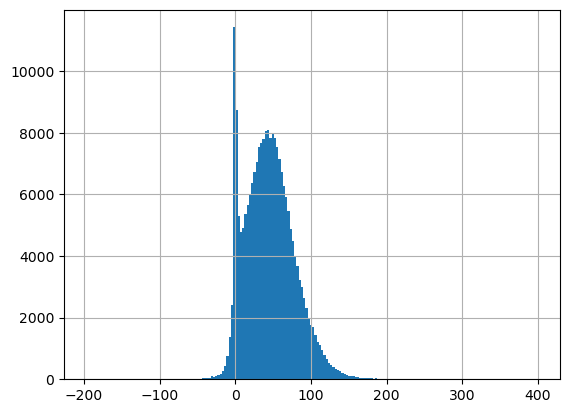

In [104]:
#outliers filtering 
wdata = wdata[(wdata['LossGivenDef']>-200) & (wdata['LossGivenDef']<400)]

wdata['LossGivenDef'].hist(bins=200)

In [105]:
# max ratio of data a column can have nulls = 80%
max_nulls = 0.7

nulls_final = wdata.isnull().sum(axis = 0)
tobe_removed = nulls_final[nulls_final > wdata.shape[0]*max_nulls]
print(tobe_removed)
wdata.drop(list(tobe_removed.index), axis=1, inplace=True)

mi_pct            166430
MI_TYPE           166430
prop_ins_ind      223951
DEAL_NAME         223951
FMOD_UPB          192130
maturity_date     192130
mod_ind           219558
MODFG_COST        219161
FMOD_DTE_year     192130
FMOD_DTE_month    192130
dtype: int64


In [106]:
#wdata.to_csv('../CleanData.csv')

# OLS

In [107]:
from math import log
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_squared_error
import random

random.seed(10)

In [108]:
# important before starting regression
#wdata = data.dropna(axis = 0)
print(wdata.shape)

(223951, 81)


In [109]:
wdata.columns

Index(['ORIG_CHN', 'ACT_PERIOD', 'orig_rt', 'orig_amt', 'orig_trm', 'oltv',
       'ocltv', 'num_bo', 'dti', 'CSCORE_B', 'CSCORE_C', 'FTHB_FLG', 'purpose',
       'PROP_TYP', 'NUM_UNIT', 'occ_stat', 'zip_3', 'msa', 'prod_type',
       'hrp_ind', 'relo_flg', 'hbl_ind', 'hltv_ref_ind', 'LAST_UPB', 'LAST_RT',
       'zb_code', 'LS_NON_INT_UPB', 'F6_curr_upb', 'F3_curr_upb',
       'F4_curr_upb', 'F1_curr_upb', 'F2_curr_upb', 'FCE_UPB',
       'z_num_months_120', 'MODTRM_CHNG', 'MODUPB_CHNG', 'dlq_status',
       'MOD_FLAG', 'CSCORE_MN', 'ORIG_VAL', 'COMPLT_FLG', 'INT_COST', 'ICSA',
       'mort30_m', 'HPI_NSA', 'UNRATE', 'state_hpi_nsa', 'state_hpi_sa',
       'orig_hpi_sa', 'method_of_foreclosurer', 'time_to_foreclose',
       'ORIG_DATE_year', 'ORIG_DATE_month', 'FIRST_PAY_year',
       'FIRST_PAY_month', 'AQSN_DTE_year', 'AQSN_DTE_month', 'LPI_DTE_year',
       'LPI_DTE_month', 'FCC_DTE_year', 'FCC_DTE_month', 'F6_DTE_year',
       'F6_DTE_month', 'F3_DTE_year', 'F3_DTE_month', 'F4_DTE

In [110]:
col_types = wdata.dtypes
list(col_types[col_types == 'object'].index)

['ORIG_CHN',
 'FTHB_FLG',
 'purpose',
 'PROP_TYP',
 'occ_stat',
 'prod_type',
 'relo_flg',
 'hbl_ind',
 'hltv_ref_ind',
 'method_of_foreclosurer']

LOSS/LGD Prediction

In [111]:
#switch here between LOSS and Lossper_GD
output = 'LossGivenDef'

# Doing a random split now, 
#can be converted into time based split later
train, test = train_test_split(wdata, test_size=0.2)

Y_train = train[output]
X_train = train.drop(output, axis=1)

Y_eval = test[output]
X_eval = test.drop(output, axis=1)

In [112]:
# calculate aic for regression
def calculate_aic(n, mse, num_params):
 aic = n * log(mse) + 2 * num_params
 return aic
# calculate bic for regression
def calculate_bic(n, mse, num_params):
 bic = n * log(mse) + num_params * log(n)
 return bic

In [113]:
num_features = ['orig_rt', 'orig_amt', 'orig_trm', 'oltv', 'ocltv', 'ORIG_DATE_year', 'FIRST_PAY_year',
    'AQSN_DTE_year','LPI_DTE_year', 'FCC_DTE_year',
        'F6_DTE_year', 'F3_DTE_year',
        'F4_DTE_year',  'F1_DTE_year',
        'F2_DTE_year',  'FCE_DTE_year',
        'zb_date_year', 'LAST_DTE_year', 
         'ICSA', 'mort30_m', 'HPI_NSA', 'UNRATE', 'state_hpi_nsa', 'state_hpi_sa']
cat_features = ['purpose', 'PROP_TYP', 'occ_stat', 'zb_code', 'ORIG_CHN', 'FTHB_FLG', 'prod_type', 'relo_flg', 'hbl_ind', 'hltv_ref_ind', 'method_of_foreclosurer']

num_transformer = Pipeline(steps=[
     ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore"))
])
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features)
    ]
)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("regressor", LinearRegression())
])

In [115]:
model.fit(X_train, Y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['orig_rt', 'orig_amt',
                                                   'orig_trm', 'oltv', 'ocltv',
                                                   'ORIG_DATE_year',
                                                   'FIRST_PAY_year',
                                                   'AQSN_DTE_year',
                                                   'LPI_DTE_year',
                                                   'FCC_DTE_year',
                                                   'F6_DTE_year', 'F3_DTE_year',
                                                   'F4_DTE_year', 'F1_DTE_year',
                                                   'F2_DTE_year',
                                                   'FCE_DTE_...
                                                   'LAST_DTE_year', 'ICSA',
                                                   'mort30_m', 'HPI_NSA',
                                                   'UNRATE', 'state_hpi_nsa',
                                                   'state_hpi_sa']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['purpose', 'PROP_TYP',
                                                   'occ_stat', 'zb_code',
                                                   'ORIG_CHN', 'FTHB_FLG',
                                                   'prod_type', 'relo_flg',
                                                   'hbl_ind', 'hltv_ref_ind',
                                                   'method_of_foreclosurer'])])),
                ('regressor', LinearRegression())])

In [116]:
Y_pred = model.predict(X_eval)
print("R^2 :", r2_score(Y_eval, Y_pred))
mse = mean_squared_error(Y_eval, Y_pred)
print("AIC", calculate_aic(Y_eval.shape[0], mse, X_eval.shape[0]))

R^2 : 0.33309868507372964
AIC 384644.9750576827
